In [1]:
using Flight.FlightCore.Systems
using Flight.FlightCore.Plotting

using Flight.FlightPhysics
using Flight.FlightComponents
using Flight.FlightAircraft.C172FBW
using Flight.FlightAircraft.C172

using UnPack
using ControlSystems
using RobustAndOptimalControl
using ComponentArrays
using LinearAlgebra

In [2]:
ac = Cessna172FBWBase(NED()) |> System #linearization requires NED kinematics

#use default trim condition
design_point = C172.TrimParameters()
test_point = C172.TrimParameters(EAS = 25, flaps = 1)

P_lss_lon = Control.Continuous.LinearizedSS(ac, design_point; model = :lon);
P_nss_lon = named_ss(P_lss_lon);

x_labels_lon = keys(P_lss_lon.x0) |> collect
y_labels_lon = keys(P_lss_lon.y0) |> collect
u_labels_lon = keys(P_lss_lon.u0) |> collect

x_labels = deleteat!(x_labels_lon, findfirst(isequal(:h), x_labels_lon))
y_labels = deleteat!(y_labels_lon, findfirst(isequal(:h), y_labels_lon))
u_labels = u_labels_lon

P_lss = Control.Continuous.submodel(P_lss_lon; x = x_labels, u = u_labels, y = y_labels)
P_nss = named_ss(P_lss);

In [4]:
dampreport(P_nss_lon)
dampreport(P_nss)

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| -0.000506          |  1            |  0.000506     |  8.05e-05     |  1.98e+03     |
| -0.0192 ±  0.233im |  0.0821       |  0.234        |  0.0373       |  52           |
| -5.55   ±   6.27im |  0.663        |  8.37         |  1.33         |  0.18         |
| -11.7              |  1            |  11.7         |  1.86         |  0.0856       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -47.2              |  1            |  47.2         |  7.51         |  0.0212       |
|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (r

We see that removing $h$ as a state eliminates an extremely slow pole, probably related to the effect of altitude on engine output. The remaining poles are virtually unaffected. Also, it significantly improves the condition of the dynamics matrix:

In [5]:
cond(P_nss_lon.A) |> display
cond(P_nss.A) |> display

1.1890917705895528e8

705827.0717951948

But a much more important reason for removing $h$ is that, even if the dynamics matrix is still invertible, the block $H_x F^{-1} G$ in the feedforward gain matrix required for $\theta$ and $EAS$ tracking is not. This is perfectly understandable: we cannot have an arbitrary combination of $\theta$ and $EAS$ and still maintain constant altitude. In other words, keeping $h$ in the state vector produces quasi-static rather than static equilibrium, and therefore we would need partitioning the state to handle it. Note that this issue is only related to the selection of the command variables $\theta$ and $EAS$, not to the system's dynamics. If we picked instead $h$ and $EAS$, we could have true static equilibrium. Thus, for this design we will use the MIMO system without $h$ as our plant baseline. Let's start by designing a full-state feedback regulator for the MIMO system.

## 1. LQR Design

In [6]:
F = P_lss.A
G = P_lss.B
Hx = P_lss.C[(:θ, :EAS), :]
Hu = P_lss.D[(:θ, :EAS), :]
# display(Hx)
# display(Hu)

n_y, n_x = size(Hx) #number of command variables and states

(2, 10)

Assemble the augmented system for LQR design by appending integrator blocks.

In [7]:
#define the blocks corresponding to the subset of the command variables for
#which integral compensation is required. in this case, since there is only one,
#we get vectors instead of row matrices, so we need need transposition
Hx_int = Hx[:EAS, :]'
Hu_int = Hu[:EAS, :]'

n_x, n_u = size(G)
n_y, _ = size(Hx) #number of command variables and states
n_int, _ = size(Hx_int)

F_aug = [F zeros(n_x, n_int); Hx_int zeros(n_int, n_int)]
G_aug = [G; Hu_int]
Hx_aug = [Hx zeros(n_y, n_int)]
Hu_aug = Hu

P_aug = ss(F_aug, G_aug, Hx_aug, Hu_aug)
controllability(F_aug, G_aug)


(iscontrollable = true, ranks = [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11], sigma_min = [0.0049300090720618885, 1.2060732253426585, 1.2060732253426585, 1.2060732253426587, 1.2060732253426587, 0.4383301346117904, 0.4336215475731614, 0.4336215475731614, 0.039893603064921915, 0.039893603064921915, 0.04012233276523918])

Design LQR and check results.

In [8]:
@unpack x0, u0 = P_lss
@unpack v_x, v_z = x0
v_norm = norm([v_x, v_z])

diagQ = ComponentVector(q = 2, θ = 20, v_x = 3/v_norm, v_z = 1/v_norm,
                        α_filt = 0, ω_eng = 0, ele_v = 0, ele_p = 0, thr_v = 0, thr_p = 0,
                        EAS_int = 0.002)

diagR = ComponentVector(ele_cmd = 0.1, thr_cmd = 0.2)

Q = ComponentMatrix(diagm(diagQ), Axis(x_labels), Axis(x_labels))
R = ComponentMatrix(diagm(diagR), Axis(x_labels), Axis(x_labels))

#compute gain matrix
C_aug = lqr(P_aug, Q, R)

#extract system state and integrator blocks
C_x = C_aug[:, 1:n_x]
C_ξ = C_aug[:, n_x+1:end]
display(C_ξ)

# quickly construct the closed-loop augmented system to check the resulting
# eigenvalues, we'll do the connections properly later
F_aug_cl = F_aug - G_aug * C_aug
P_aug_cl = ss(F_aug_cl, G_aug, Hx_aug, Hu_aug)

dampreport(P_aug)
dampreport(P_aug_cl)

2×1 Matrix{Float64}:
 -0.04024424952731322
  0.09586553174369135

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| +0                 |  -1           |  0            |  0            |  -Inf         |
| -0.0195 ±  0.232im |  0.0838       |  0.232        |  0.037        |  51.4         |
| -5.55   ±   6.27im |  0.663        |  8.37         |  1.33         |  0.18         |
| -11.7              |  1            |  11.7         |  1.86         |  0.0856       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -47.2              |  1            |  47.2         |  7.51         |  0.0212       |
|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (r

Define all gain block and integrator systems:

In [9]:
A = [F G; Hx Hu]
B = inv(A)
B_12 = B[1:n_x, n_x+1:end]
B_22 = B[n_x+1:end, n_x+1:end]

C_fbk = C_x
C_fbk_ss = named_ss(ss(C_fbk), u = x_labels, y = [:e_fbk, :t_fbk])

C_fwd = B_22 + C_x * B_12
C_fwd_ss = named_ss(ss(C_fwd), u = [:θ_fwd, :EAS_fwd], y = [:e_fwd, :t_fwd])

#provide as many integrators as command variables, regardless of how many of
#them actually require integral compensation
int_ss = named_ss(ss(tf(1, [1,0])) .* I(2),
                    x = [:ξ_e, :ξ_t],
                    u = [:e_int_in, :t_int_in],
                    y = [:e_int_out, :t_int_out]);

#then the integral gain matrix is constructed by padding C_ξ with zeros in those
#columns corresponding to command variables without integral compensation
C_int = ComponentMatrix(zeros(n_u, n_y), Axis(u_labels), Axis(:θ, :EAS))
C_int[:, :EAS] .= C_ξ
C_int_ss = named_ss(ss(C_int), u = [:θ_int, :EAS_int], y = [:e_int_in, :t_int_in])

#we could instead use a scalar integrator for EAS and delete the whole θ_int
#path, including θ_sum, θ_sum_in, θ_sum_dmd_in

display(C_fbk_ss)
display(C_fwd_ss)
display(C_int_ss)
display(int_ss)

NamedStateSpace{Continuous, Float64}
D = 
 3.6965128234275646   15.199222636575183   -0.21738505886276566  -0.24370454805898517   10.436003801478293    0.00024047790809692414   0.036851450145827185   2.0594317488399825    -0.0001300320846650063  0.003435945731386288
 0.28026854142459484  -2.0491348064735457   0.5669404564661666    0.032318134277715876  -0.14132785902751044  0.000977691436382431    -6.501604233250315e-5  -0.009060594075118241   0.0011817930354137108  0.04524593142527759

Continuous-time state-space model
With state  names: 
     input  names: q θ v_x v_z α_filt ω_eng ele_v ele_p thr_v thr_p
     output names: e_fbk t_fbk


NamedStateSpace{Continuous, Float64}
D = 
 14.875290691694941  -0.2676922471355922
  3.12231573166454    0.6267937051232494

Continuous-time state-space model
With state  names: 
     input  names: θ_fwd EAS_fwd
     output names: e_fwd t_fwd


NamedStateSpace{Continuous, Float64}
D = 
 0.0  -0.04024424952731322
 0.0   0.09586553174369135

Continuous-time state-space model
With state  names: 
     input  names: θ_int EAS_int
     output names: e_int_in t_int_in


NamedStateSpace{Continuous, Float64}
A = 
 0.0  0.0
 0.0  0.0
B = 
 1.0  0.0
 0.0  1.0
C = 
 1.0  0.0
 0.0  1.0
D = 
 0.0  0.0
 0.0  0.0

Continuous-time state-space model
With state  names: ξ_e ξ_t
     input  names: e_int_in t_int_in
     output names: e_int_out t_int_out


Define the properly labelled junctions and connections:

In [21]:
θ_sum = sumblock("θ_sum_out = θ_sum_in - θ_dmd_sum_in")
EAS_sum = sumblock("EAS_sum_out = EAS_sum_in - EAS_dmd_sum_in")
elevator_sum = sumblock("e_cmd = e_fwd - e_fbk - e_int_out")
throttle_sum = sumblock("t_cmd = t_fwd - t_fbk - t_int_out")

θ_dmd_splitter = splitter(:θ_dmd, 2)
EAS_dmd_splitter = splitter(:EAS_dmd, 2)

test_connections = vcat(
    Pair.(C_fbk_ss.u, C_fbk_ss.u),
    :e_fwd => :e_fwd,
    :t_fwd => :t_fwd,
    :e_fbk => :e_fbk,
    :t_fbk => :t_fbk,
    :e_int_out => :e_int_out,
    :t_int_out => :t_int_out,
    :θ_dmd1 => :θ_dmd_sum_in,
    :θ_dmd2 => :θ_fwd,
    :EAS_dmd1 => :EAS_dmd_sum_in,
    :EAS_dmd2 => :EAS_fwd,
    :θ_sum_out => :θ_int,
    :EAS_sum_out => :EAS_int,
    :e_int_in => :e_int_in,
    :t_int_in => :t_int_in,
    :θ => :θ_sum_in, #causes complaint about single output to multiple inputs
    :EAS => :EAS_sum_in,
    :e_cmd => :elevator_cmd,
    :t_cmd => :throttle_cmd,
    )


connections = vcat(test_connections)

P_nss_θv = connect([P_nss, int_ss, C_fwd_ss, C_fbk_ss, C_int_ss,
                    θ_sum, EAS_sum, elevator_sum, throttle_sum,
                    θ_dmd_splitter, EAS_dmd_splitter], connections;
                    w1 = [:θ_dmd, :EAS_dmd], z1 = vcat(y_labels, [:e_int_out, :t_int_out]))

dampreport(P_aug_cl)
dampreport(P_nss_θv)
#note the pole at the origin in P_nss_θv not present in P_aug_cl. It corresponds
#to the integrator in the θ path, which is multiplied by the zero gain column in
#C_int, and therefore has no effect (it is exactly cancelled by a zero)
zpk(P_nss_θv[:θ, :θ_dmd])

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| -0.178             |  1            |  0.178        |  0.0284       |  5.61         |
| -1.11   ±  0.312im |  0.963        |  1.16         |  0.184        |  0.897        |
| -6.49              |  1            |  6.49         |  1.03         |  0.154        |
| -11.6              |  1            |  11.6         |  1.85         |  0.086        |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -36.5              |  1            |  36.5         |  5.82         |  0.0274       |
| -20.9   ±     37im |  0.492        |  42.5         |  6.77         |  0.0477       |
| -46.3              |  1            |  46.3         |  7.36         |  0.0216       |
|        Pole        |   Damping     |   Fr

┌ Warning: Connecting single output to multiple inputs Y1=Union{Nothing, Int64}[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 22, 23, 24, 25, 20, 21, 32, 33, 34, 35, 28, 29, 26, 27, 2, 14, 30, 31]
└ @ ControlSystemsBase C:\Users\Miguel\.julia\packages\ControlSystemsBase\TuYDk\src\connections.jl:327


TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                                                    (1.0s + 49.60853672813754)(1.0s^2 + 37.694986438244484s + 986.7315873915006)(1.0s + 11.61513222240709)(1.0s + 2.1228773628364115)(1.0s + 1.2269009550707806)(1.0s + 0.17851267664829154)(1.0s - 3.861511300520319e-15)
205606.75345889005--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                  (1.0s + 46.26993592920262)(1.0s + 36.54099951027883)(1.0s^2 + 41.89153454306714s + 1809.8161927753479)(1.0s^2 + 37.69620532515436s + 986.9093936483509)(1.0s + 11.624395394579512)(1.0s + 6.486294638605317)(1.0s^2 + 2.2292335670684356s + 1.3398667635680592)(1.0s + 0.17815610978889082)(1.0s

StepInfo:
Initial value:     0.000
Final value:       1.000
Step size:         1.000
Peak:              1.000
Peak time:         9.999 s
Overshoot:          0.00 %
Undershoot:         0.00 %
Settling time:     2.632 s
Rise time:         1.400 s


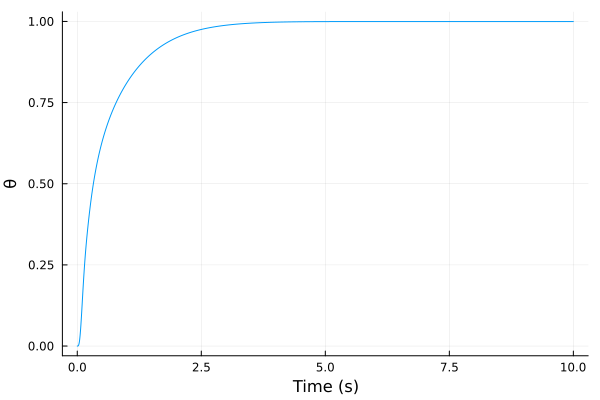

In [11]:
θdmd2θ = P_nss_θv[:θ, :θ_dmd]
θdmd2e = P_nss_θv[:elevator_cmd, :θ_dmd]
step(θdmd2θ, 10) |> stepinfo |> display
step(θdmd2θ, 10) |> plot
# step(θdmd2e, 10) |> plot!

StepInfo:
Initial value:     0.000
Final value:       1.006
Step size:         1.006
Peak:              1.095
Peak time:         3.573 s
Overshoot:          8.89 %
Undershoot:         0.00 %
Settling time:    11.471 s
Rise time:         1.246 s


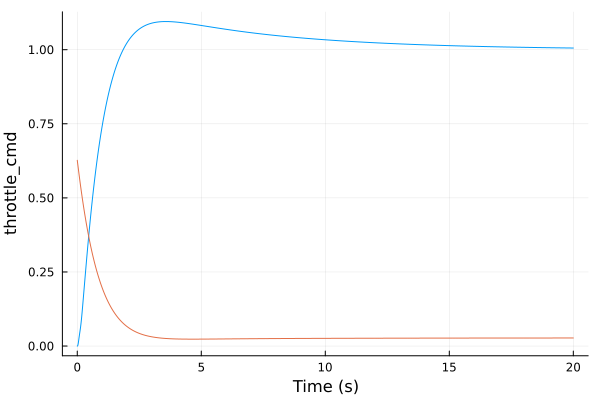

In [12]:
vdmd2v = P_nss_θv[:EAS, :EAS_dmd]
vdmd2t = P_nss_θv[:throttle_cmd, :EAS_dmd]
step(vdmd2v, 20) |> stepinfo |> display
step(vdmd2v, 20) |> plot
step(vdmd2t, 20) |> plot!

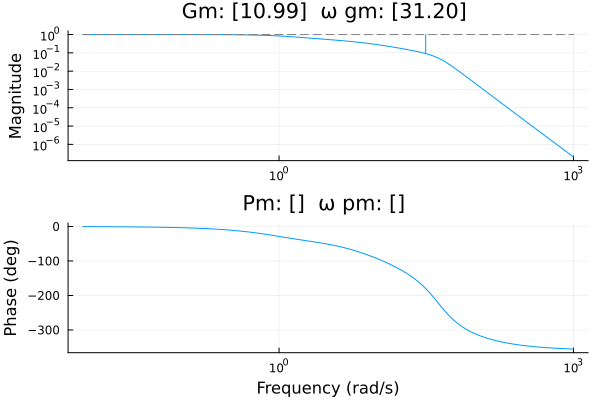

In [13]:
marginplot(θdmd2θ)

## 3. Pitch Rate Tracker

Now, on top of the $\theta$ + $EAS$ tracker we can provide a pitch rate tracker by adding an integrator upstream of the $\theta_{dmd}$ input:

In [14]:
q_int = tf(1, [1, 0])
q_ff = named_ss(q_int |> ss, u = :q_dmd, y = :θ_dmd)
P_nss_qv = connect([q_ff, P_nss_θv], [:θ_dmd => :θ_dmd]; w1 = [:q_dmd, :EAS_dmd], z1 = P_nss_θv.y)
qdmd2q = P_nss_qv[:q, :q_dmd];

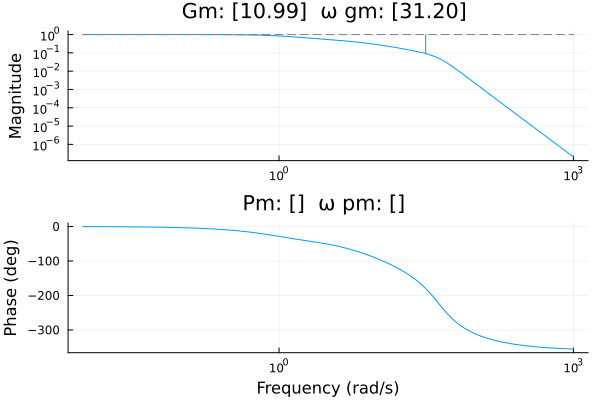

In [15]:
marginplot(qdmd2q)

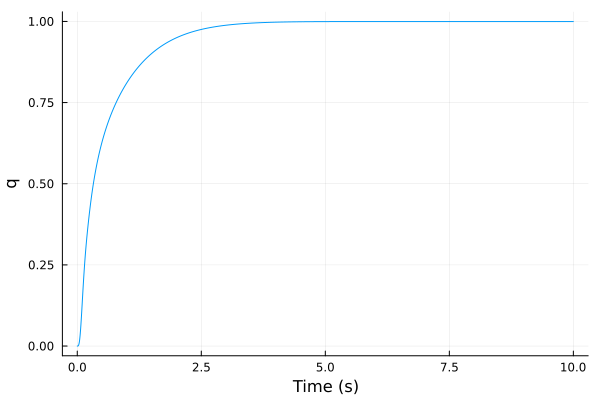

In [16]:
step(qdmd2q, 10) |> plot

In the actual implementation, $\dot{\theta}$ should not be computed directly as $\dot{\theta} = q_{dmd}$ but through the kinematic relation:
$$ q(\dot{\theta}, r, \phi) = \dfrac{1}{\cos \phi}(\dot{\theta} + r \tan \phi) $$
$$ \dot{\theta}_{dmd} = q_{dmd} \cos \phi - r \tan \phi$$